# Tikhonov Regularization

Find a parameter $m$ that solves the inverse problem $\mathcal{F}\, m = d$ in a *least squares sense*.
Specifically, we solve the minimization problem

$$ \min_m \frac{1}{2} \int_0^L (\mathcal{F}\, m - d )^2 dx + \frac{\alpha}{2} \mathcal{R}(m), $$

where the Tikhonov regularization $\mathcal{R}(m)$ is a quadratic functional of $m$.
In what follows, we will penalize the $L^2$-norm of the parameter and let $\mathcal{R}(m) = \int_0^L m^2 dx$. However other choices are possible; for example by penalizing the $L^2$-norm of the gradient of $m$ ($\mathcal{R}(m) = \int_0^L m_x^2$), one will favor smoother solutions.

The regularization parameter $\alpha$ needs to be chosen appropriately. If $\alpha$ is small, the computation of the initial condition $m$ is unstable as in the naive approach. On the other hand, if $\alpha$ is too large, information is lost in the reconstructed $m$. Various criteria -- such as Morozov's discrepancy principle or L-curve criterion  -- can be used to find the optimal amount of regularization.



## Morozov's discrepancy principle

The discrepancy principle, due to Morozov, chooses the regularization parameter to be the largest value of $\alpha$ such that the norm of the misfit is bounded by the noise level in the data, i.e.,

$$ \| \mathcal{F}\,m_\alpha - d \| \leq \delta, $$ 

where $\delta$ is the noise level. Here, $m_\alpha$ denotes the parameter found minimizing the Tikhonov regularized minimization problem with parameter $\alpha$. This choice aims to avoid overfitting of the data, i.e., fitting the noise.

## L-curve criterion

Choosing $\alpha$ parameter using the L-curve criterion requires the solution of inverse problems for a sequence of regularization parameters. Then, for each $\alpha$, the norm of the data misfit (also called residual) $\| \mathcal{F}\,m_\alpha - d \|$ is plotted against the norm of the regularization term $\|m_\alpha\|$ in a log-log plot.
This curve is usually found to be L-shaped and thus has an *elbow*, i.e. a point of greatest curvature. The L-curve criterion chooses the regularization parameter corresponding to that point. The idea behind the L-curve criterion is that this choice for the regularization parameter is a good compromise between fitting the data and controlling the stability of the parameters. A smaller $\alpha$, which correspond to points to the left of the optimal value, only leads to a slightly better data fit while significantly increasing the norm of the parameters. Conversely, larger $\alpha$, corresponding to points to the right of the optimal value, slightly decrease the norm of the solution, but they increase the data misfit significantly.



## Discretization
In the discrete setting, the Tikhonov regularized solution $\mathbf{m}_{\alpha}$ solves the penalized least squares problem

$$ \min_{\mathbf{m}} \frac{1}{2} \| F\, \mathbf{m} - \mathbf{d} \|^2 + \frac{\alpha}{2} \| \mathbf{m} \|^2, $$

where $\| \cdot \|$ denotes the Euclidean vector norm in $\mathbb{R}^n$.

$\mathbf{m}_{\alpha}$ can then be computed by solving the normal equations

$$ ( F^t F + \alpha I) \mathbf{m}_{\alpha} = F^t \mathbf{d}.$$

#### Recall the heat equation:

Given
- the initial temperature profile $u(x,0) = m(x)$,
- the thermal diffusivity $k$,
- a prescribed temperature $u(0,t) = u(L,t) = 0$ at the ends of the rod,

solve the heat equation

$$
\left\{
\begin{array}{ll}
\frac{\partial u}{\partial t} - k \frac{\partial^2}{\partial x^2} u = 0 & \forall x\,\in\,(0, L)\; \forall t \in (0,T)\\
u(x, 0) = m(x) & \forall x \in [0,L] \\
u(0,t) = u(L,t) = 0 & \forall t \in (0, T],
\end{array}
\right.
$$

and observe the temperature at the final time $T$:

$$ \mathcal{F}(m) = u(x, T). $$



In [1]:
from __future__ import print_function, absolute_import, division

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=SMALL_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
plt.rc('legend', fontsize=SMALL_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)  

def plot(f, style, **kwargs):
    x = np.linspace(0., L, nx+1)
    f_plot = np.zeros_like(x)
    f_plot[1:-1] = f
    plt.plot(x,f_plot, style, **kwargs)
    
def assembleMatrix(k, h, dt, n):
    diagonals = np.zeros((3, n))   # 3 diagonals
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    K = k*sp.spdiags(diagonals, [-1,0,1], n,n)
    M = sp.spdiags(np.ones(n), 0, n,n)
    
    return M + dt*K
    
def solveFwd(m, k, h, dt, n, nt):
    A = assembleMatrix(k, h, dt, n)
    u_old = m.copy()
    for i in np.arange(nt):
        u = la.spsolve(A, u_old)
        u_old[:] = u
        
    return u  

def assembleF(k, h, dt, n, nt):
    F = np.zeros((n,n))
    m_i = np.zeros(n)
    
    for i in np.arange(n):
        m_i[i] = 1.0
        F[:,i] = solveFwd(m_i, k, h, dt, n, nt)
        m_i[i] = 0.0

    return F

def solveTikhonov(d, F, alpha):    
    H = np.dot( F.transpose(), F) + alpha*np.identity(F.shape[1])
    rhs = np.dot( F.transpose(), d)
    return np.linalg.solve(H, rhs)

### Solution of regularized problem

The code below finds the Tikhonov regularized solution $\mathbf{m}_{\alpha}$ for $\alpha = 10^{-3}$.

> **Disclaimer**: In the code below, for simplicity, we explicitly construct and factorize the matrix $F^t F + \alpha I$. This approach is not feasible and should **never** be used to solve real problems (the computational cost is  $\mathcal{O}(n^3)$). Instead, as we will see, one should solve the normal equations using the conjugate gradient algorithm, which only requires the ability to compute the action of $F^t F + \alpha I$ on a few given directions $\mathbf{m}$, and is guaranteed to converge in a number of iterations that is independent of $n$.

/Users/omar/opt/anaconda3/envs/myconda/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


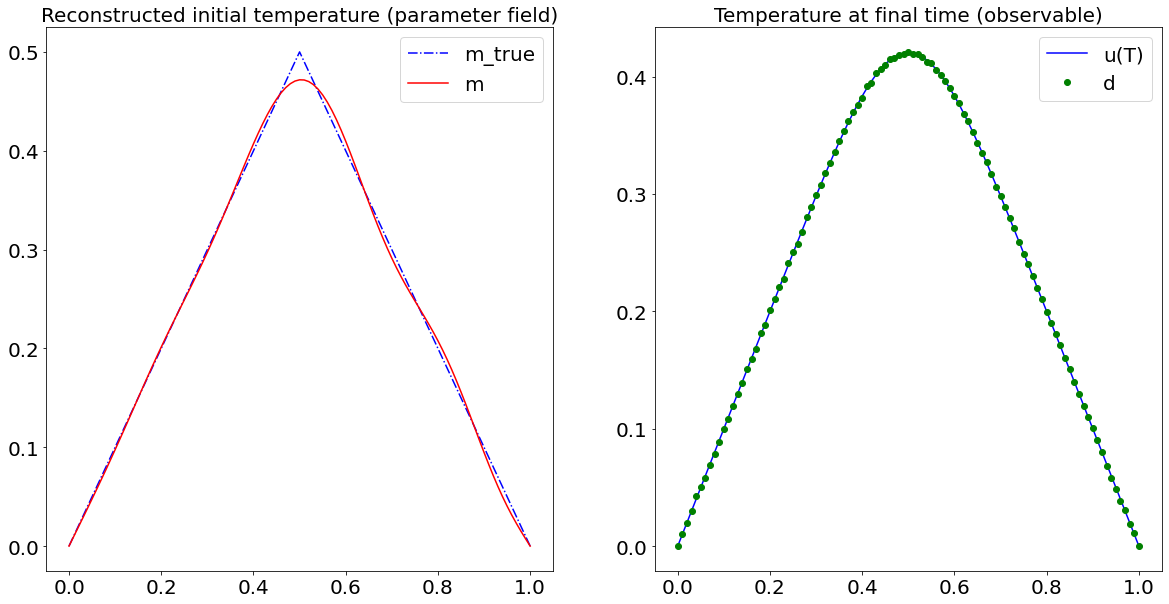

In [12]:
## Setup the problem

# physical parameters
T = 1.0
L = 1.0
k = 0.005

# discretization
nx = 100
nt = 100
h = L/float(nx)
dt = T/float(nt)
x = np.linspace(0.+h, L-h, nx-1)

# true solution
m_true = 0.5 - np.abs(x-0.5)
u_true = solveFwd(m_true, k, h, dt, nx-1, nt)

# noise and data
noise_std_dev = 1e-3
d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

# regularization parameter
alpha = 1e-3

# invert for m
F = assembleF(k, h, dt, nx-1, nt)
m = solveTikhonov(d, F, alpha)

# plot results
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot(m_true, "-.b", label = 'm_true')
plot(m, "-r", label = 'm')
plt.legend()
plt.title("Reconstructed initial temperature (parameter field)")
plt.subplot(1,2,2)
plot(u_true, "-b", label = 'u(T)')
plot(d, "og", label = 'd')
plt.legend()
plt.title("Temperature at final time (observable)")
plt.show()

### Another example:

We consider the same inverse heat equation problem above
with $L=1$, $T=0.1$, $k=0.01$.

As initial condition use the (discrete version of) the true initial temperature profile 

$$
m_{\text{true} } = \max(0, 1 - |1 - 4x|) + 100\, x^{10}(1-x)^2.
$$

The resulting noisy observation of the final time temperature profile is $\mathbf{d} = F \mathbf{m} + \mathbf{n}$,
where the noise $\mathbf{n}$ is normally distributed with mean zero and
variance $\sigma^2 = 10^{-4}$. 

/Users/omar/opt/anaconda3/envs/myconda/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


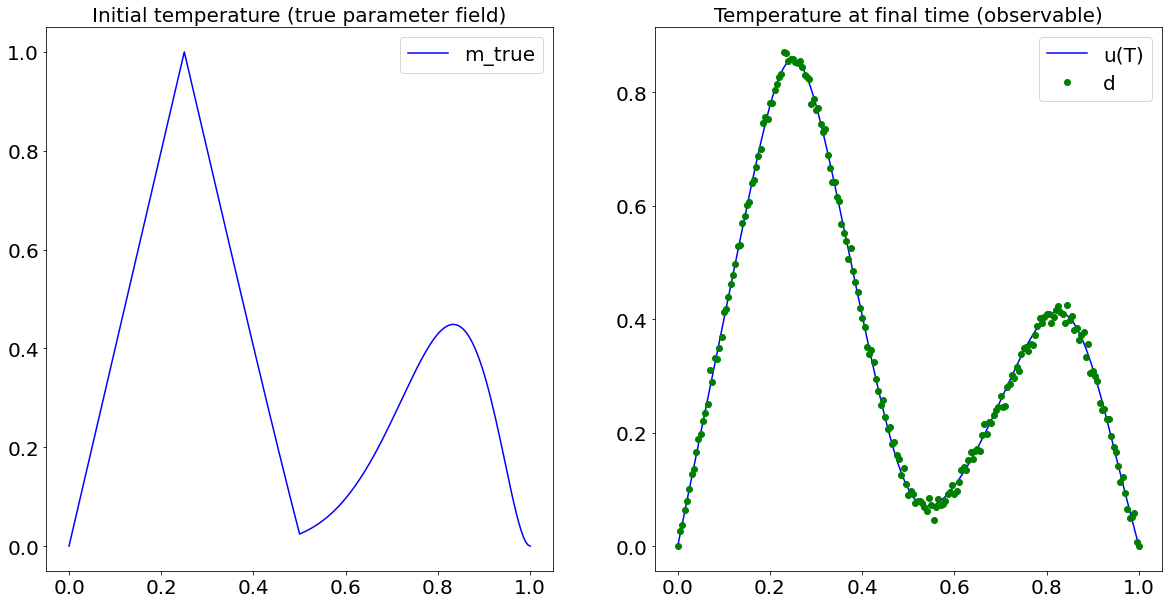

In [15]:
L = 1.
T = 0.1
k = 0.01

nx = 200
nt = 100

noise_std_dev = 1e-2

h = L/float(nx)
dt = T/float(nt)

## Compute the data d by solving the forward model
x = np.linspace(0.+h, L-h, nx-1)

## Compute the data d by solving the forward model
x = np.linspace(0.+h, L-h, nx-1)
m_true = np.maximum( np.zeros_like(x), 1. - np.abs(1. - 4.*x)) + 100.*np.power(x,10)*np.power(1.-x,2)
u_true = solveFwd(m_true, k, h, dt, nx-1, nt)
d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plot(m_true, "b", label = 'm_true')
plt.legend()
plt.title("Initial temperature (true parameter field)")
plt.subplot(1,2,2)
plot(u_true, "-b", label = 'u(T)')
plot(d, "og", label = 'd')
plt.legend()
plt.title("Temperature at final time (observable)")
plt.show()


### Effect of the regularization parameter

We use Tikhonov regularization with $\alpha = 0.0001,0.001,0.01,0.1,1$ to compute the regularized
reconstructions $\mathbf{m}_\alpha$.

/Users/omar/opt/anaconda3/envs/myconda/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


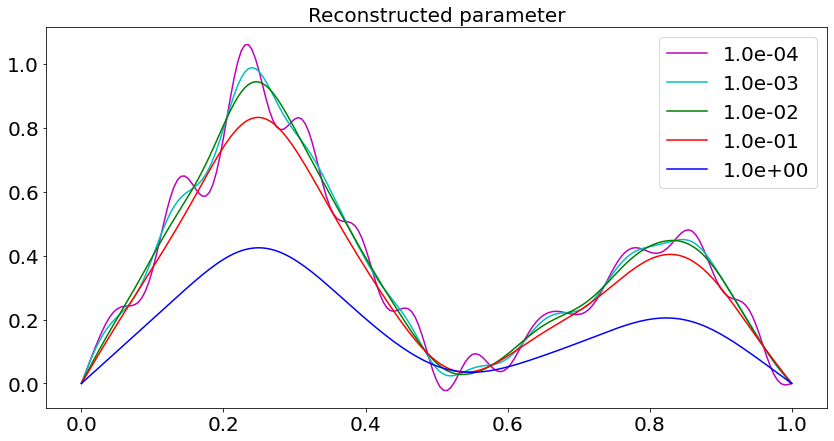

In [16]:
F = assembleF(k, h, dt, nx-1, nt)

colors = ['b', 'r', 'g', 'c', 'm']
plt.figure(figsize=(14,7))
for alpha in [1e-4, 1e-3, 1e-2, 1e-1, 1.]:
    m_alpha = solveTikhonov(d, F, alpha)
    plot(m_alpha, "-"+colors.pop(), label = '{0:.1e}'.format(alpha))

plt.legend()
plt.title("Reconstructed parameter")
plt.show()

In the *eye norm*, the best reconstruction $\mathbf{m}_\alpha$ is for $\alpha$ between $0.01$ and $0.001$. For such values of $\alpha$ the reconstructed solution well captures the smooth features of the true parameter, and it does not present spurious oscillations.

### L-curve approach to choose optimal $\alpha$


/Users/omar/opt/anaconda3/envs/myconda/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


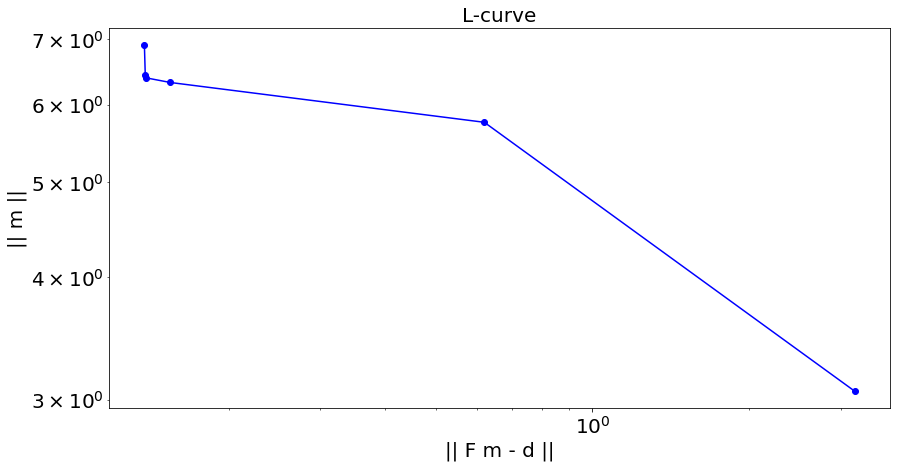

In [17]:
norm_m = [] #norm of parameter
norm_r = [] #norm of misfit (residual)
plt.figure(figsize=(14,7))
for alpha in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]:
    m_alpha = solveTikhonov(d, F, alpha)
    norm_m.append( np.sqrt( np.dot(m_alpha,m_alpha) ) )
    u_alpha = solveFwd(m_alpha, k, h, dt, nx-1, nt)
    norm_r.append( np.sqrt( np.dot(d-u_alpha,d-u_alpha) ) )
    
plt.loglog(norm_r, norm_m, "-ob")
plt.xlabel("|| F m - d ||")
plt.ylabel("|| m ||")
plt.title("L-curve")
plt.show()

The *elbow* of the L-curve is located between $\alpha = 10^{-4}$ and $\alpha = 10^{-3}$. 

### Optimal $\alpha$ based on Morozov's principle

We find the largest value of $\alpha$ such that 

$$
\|F\,\mathbf{m}_\alpha - \mathbf{d}\| \le \delta
$$

where $\delta=\| \mathbf{n}\|$ and $\mathbf{m}_\alpha$ is the solution of the Tikhonov-regularized inverse problem with regularization parameter $\alpha$.

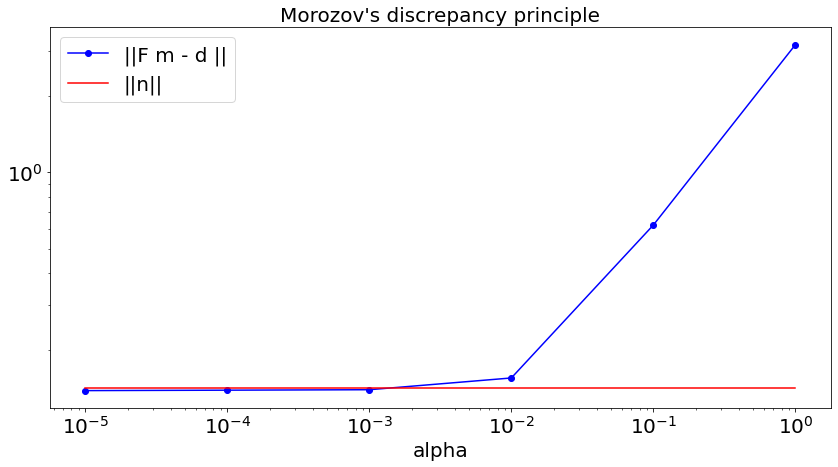

In [18]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]
norm_r = [] #norm of misfit (residual)
plt.figure(figsize=(14,7))
for alpha in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]:
    m_alpha = solveTikhonov(d, F, alpha)
    u_alpha = solveFwd(m_alpha, k, h, dt, nx-1, nt)
    norm_r.append( np.sqrt( np.dot(d-u_alpha,d-u_alpha) ) )
    
plt.loglog(alphas, norm_r, "-ob", label="||F m - d ||")
plt.loglog(alphas, [noise_std_dev*np.sqrt(nx-1)]*len(alphas), "-r", label="||n||")
plt.xlabel("alpha")
plt.legend()
plt.title("Morozov's discrepancy principle")
plt.show()

Since the noise $\mathbf{n}$ is a i.i.d. Gaussian vector in $\mathbb{R}^n$ with marginal variance $\sigma^2=10^{-4}$, then we expect the $\delta = \|\mathbf{n}\|$ to be of the order of $\sqrt{ n \sigma^2}$.

The figure above compares the norm of the misfit $\|F \mathbf{m}_\alpha - \mathbf{d} \|$ (blue line) with $\delta$ (read line). The Morozov's discrepancy principal then suggests that the optimal $\alpha$ is near $10^{-2}$ (i.e. where the two lines intersect).

### Reconstruction error

Since we know the true initial condition $\mathbf{m}_{\text{true}}$, we can explicitly compute the error in the reconstruction, $\|\mathbf{m}_{\text{true}}-\mathbf{m}_\alpha\|$, and plot it as a function of $\alpha$, where $\mathbf{m}_\alpha$ is the Tikhonov regularized solution.

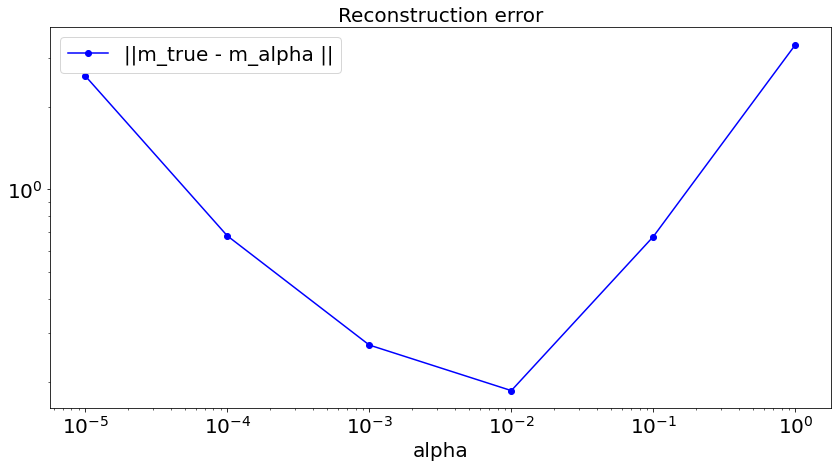

In [19]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]
err_m = [] #norm of misfit (residual)
plt.figure(figsize=(14,7))
for alpha in alphas:
    m_alpha = solveTikhonov(d, F, alpha)
    err_m.append( np.sqrt( np.dot(m_true-m_alpha,m_true-m_alpha) ) )
    
plt.loglog(alphas, err_m, "-ob", label="||m_true - m_alpha ||")
plt.xlabel("alpha")
plt.legend()
plt.title("Reconstruction error")
plt.show()

The $\alpha$ obtained using the Morozov's discrepancy principle is very close to the value of $\alpha$ that minimizes the reconstruction error in the $L^2(\Omega)$ norm. The $\alpha$ obtained using the L-curve criterion is smaller than the value of $\alpha$ that minimizes the reconstruction error in the $L^2(\Omega)$ norm, thus indicating that the L-curve criterion underestimates the amount of regularization necessary for solving this inverse problem.

## Tikhonov regularization on the gradient of $m$

Consider the Tikhonov regularized solution $m_\alpha$ where we penalize the norm of the *gradient* of $m$.
That is, $m_\alpha$ solves minimization problem

$$ \min_m \frac{1}{2} \int_0^L (\mathcal{F}\, m - d )^2 dx + \frac{\alpha}{2} \int_0^L m_x^2 \, dx. $$

In [ ]:
L = 1.
T = 0.1
k = 0.01

nx = 200
nt = 100

noise_std_dev = 1e-2

h = L/float(nx)
dt = T/float(nt)

## Compute the data d by solving the forward model
x = np.linspace(0.+h, L-h, nx-1)
m_true = np.maximum( np.zeros_like(x), 1. - np.abs(1. - 4.*x)) + 100.*np.power(x,10)*np.power(1.-x,2)
u_true = solveFwd(m_true, k, h, dt, nx-1, nt)
d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

# Assemble the regularization matrix corresponding to the laplacian of m
R = -np.diag(np.ones(d.shape[0]-1), -1) + 2*np.diag(np.ones(d.shape[0]),0) - np.diag(np.ones(d.shape[0]-1), 1)
R*= h**(-2)

F = assembleF(k, h, dt, nx-1, nt)

def solveTikhonov2(d, F, R, alpha): 
    H = np.dot( F.transpose(), F) + alpha*R
    rhs = np.dot( F.transpose(), d)
    return np.linalg.solve(H, rhs)

colors = ['b', 'r', 'g', 'c', 'm']
plt.figure(figsize=(14,7))
for alpha in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    m_alpha = solveTikhonov2(d, F, R, alpha)
    plot(m_alpha, "-"+colors.pop(), label = 'alpha = {0:.1e}'.format(alpha))

plt.legend()
plt.title("Reconstructed parameter")
plt.show()

### L-curve approach to choose optimal $\alpha$


In [ ]:
norm_m = [] #norm of parameter
norm_r = [] #norm of misfit (residual)
plt.figure(figsize=(14,7))
for alpha in [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    m_alpha = solveTikhonov2(d, F, R, alpha)
    norm_m.append( np.sqrt( np.dot(m_alpha,m_alpha) ) )
    u_alpha = solveFwd(m_alpha, k, h, dt, nx-1, nt)
    norm_r.append( np.sqrt( np.dot(d-u_alpha,d-u_alpha) ) )
    
plt.loglog(norm_r, norm_m, "-ob")
plt.xlabel("|| F m - d ||")
plt.ylabel("|| m ||")
plt.title("L-curve")
plt.show()

The optimal $\alpha$ should be chosen between $10^{-7}$ and $10^{-5}$.

### Optimal $\alpha$ based on Morozov's principle

In [ ]:
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
norm_r = [] #norm of misfit (residual)
plt.figure(figsize=(14,7))
for alpha in alphas:
    m_alpha = solveTikhonov2(d, F, R, alpha)
    u_alpha = solveFwd(m_alpha, k, h, dt, nx-1, nt)
    norm_r.append( np.sqrt( np.dot(d-u_alpha,d-u_alpha) ) )
    
plt.loglog(alphas, norm_r, "-ob", label="||F m - d ||")
plt.loglog(alphas, [noise_std_dev*np.sqrt(nx-1)]*len(alphas), "-r", label="||n||")
plt.xlabel("alpha")
plt.legend()
plt.title("Morozov's discrepancy principle")
plt.show()

According to the Morozov's discrepancy principle, $\alpha$ should be chosen between $10^{-5}$ and $10^{-4}$.

Copyright &copy; 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright &copy; 2019, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis. <br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.